# Fine-Tuning BERT for Sentence Pair Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

# checking tenserflow gpu
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Importing libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf_keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
import random
# random.seed(101) # AUC - 0.90
# random.seed(111) # AUC - 0.99
# random.seed(113) # AUC - 0.92

random.seed(911) # AUC - 


plt.style.use('ggplot')
os.environ["TOKENIZERS_PARALLELISM"] = "true"

%matplotlib inline

plt.rcParams["figure.figsize"] = (8, 6)
plt.style.use("default")

max_length = 192 # Token Length for Evidence Identification
max_length = 288 # Token Length for Evidence Classification [192/256/288/320/384/448/512]

# Model set and batch size
model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "bert-base-uncased"

batch_size = 1 # Batch size for Evidence Classification
batch_size = 4 # Batch size for Evidence Identification Bert  batch 4 and max length 288 works
# batch_size = 16 # Batch size for Evidence Identification Distilbert

batch_size = 3
max_length = 512
num_epochs = 20

In [3]:
# Reading the data
train_fname = "./data/train_evidence_class.csv"
train_df = pd.read_csv(train_fname)
print(train_df.shape)

val_df = pd.read_csv("./data/dev_evidence_class.csv")
print(val_df.shape)

test_df = pd.read_csv("./data/test.csv")
test_df.shape

(96, 6)
(32, 6)


(5977, 5)

In [4]:
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())

label
NOT ENOUGH INFO    40
REFUTES            38
SUPPORTS           18
Name: count, dtype: int64
label
REFUTES            13
NOT ENOUGH INFO    13
SUPPORTS            6
Name: count, dtype: int64


In [5]:
# Printing the first 5 rows
train_df.head()

,id,rumor,label,evidence_id,evidence,username
0,AuRED_014,aurgent Ramallah Ministry of Health spokesman ...,REFUTES,"['1357211717479116800', '1356683687870488576',...",picture from the launch of the vaccination cam...,"['palestine_moh', 'palestine_moh', 'palestine_..."
1,AuRED_037,Macron to Sky News after my visit to Mrs Fairo...,REFUTES,"['1301079467889131522', '1301067546200858626',...",RT Macron and Mrs Fairouz this news be not pub...,"['salmanonline', 'salmanonline', 'salmanonline']"
2,AuRED_085,Saudi Arabia evacuate student from China in pl...,REFUTES,"['1226482043007066113', '1225345358961762304',...",RT the Yemeni Embassy in China announce the st...,"['YSUCORG', 'YSUCORG', 'Yemen_PM', 'Yemen_PM',..."
3,AuRED_089,the Corona epidemic have reach the Emirates wi...,REFUTES,"['1222506828694794240', '1223649306667778049',...",today confirm the emergence of the case of the...,"['WHOEMRO', 'mohapuae', 'mohapuae', 'mohapuae'..."
4,AuRED_135,the official spokesman for the Football Associ...,REFUTES,"['1585012773125120000', '1585011015032315904']",Islam Al Shater awarnsa against fabricate news...,"['AlAhlyTV', 'AlAhlyTV']"


In [6]:
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())

label
NOT ENOUGH INFO    40
REFUTES            38
SUPPORTS           18
Name: count, dtype: int64
label
REFUTES            13
NOT ENOUGH INFO    13
SUPPORTS            6
Name: count, dtype: int64


In [7]:
train_df[train_df['label']=='NOT ENOUGH INFO']

,id,rumor,label,evidence_id,evidence,username
18,AuRED_004,turkish demonstrator attack the Kuwaiti Turkis...,NOT ENOUGH INFO,[],NaN,[]
19,AuRED_006,qaissaeed afrom now on if cleric interfere in ...,NOT ENOUGH INFO,[],NaN,[]
20,AuRED_009,Erdogan my problem with Sisi be due to misunde...,NOT ENOUGH INFO,[],NaN,[]
21,AuRED_015,dThe Guardian warn of the outbreak of deadly v...,NOT ENOUGH INFO,[],NaN,[]
22,AuRED_022,proudly make in Egypt dad Rami Al Subaie the E...,NOT ENOUGH INFO,[],NaN,[]
23,AuRED_032,ElBaradei speak again Egypt possession of nucl...,NOT ENOUGH INFO,[],NaN,[]
24,AuRED_052,news about the death of saudi judo player Taha...,NOT ENOUGH INFO,[],NaN,[]
25,AuRED_057,aThe saudi swimmer aAhmed Jibrila rank in the ...,NOT ENOUGH INFO,[],NaN,[]
26,AuRED_058,Ahmed Moussa Egypt succeed in organize the Wor...,NOT ENOUGH INFO,[],NaN,[]
27,AuRED_063,pardon terrorist be something God can do but m...,NOT ENOUGH INFO,[],NaN,[]


In [8]:
val_df[val_df['label']=='NOT ENOUGH INFO']

,id,rumor,label,evidence_id,evidence,username
19,AuRED_045,acuba announce the success of its vaccine aAbd...,NOT ENOUGH INFO,[],NaN,[]
20,AuRED_025,Torres Gomez member of the Board of Directors ...,NOT ENOUGH INFO,[],NaN,[]
21,AuRED_026,adforce the legend Cristiano to wear the gay s...,NOT ENOUGH INFO,[],NaN,[]
22,AuRED_088,Algeria reject public normalization and prefer...,NOT ENOUGH INFO,[],NaN,[]
23,AuRED_066,egyptjoiningnatomembersdad NATO member state a...,NOT ENOUGH INFO,[],NaN,[]
24,AuRED_053,the french club Paris Saint Germain achieve fa...,NOT ENOUGH INFO,[],NaN,[]
25,AuRED_046,the algerian medical delegation that be send t...,NOT ENOUGH INFO,[],NaN,[]
26,AuRED_059,Urgent ai ai ai ai Hafeez Draghi be expel from...,NOT ENOUGH INFO,[],NaN,[]
27,AuRED_033,after his appointment as Vice President of the...,NOT ENOUGH INFO,[],NaN,[]
28,AuRED_001,aMusa Abu Marzouq Al Hamsawi congratulate the ...,NOT ENOUGH INFO,[],NaN,[]


In [9]:
# Information about dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           96 non-null     object
 1   rumor        96 non-null     object
 2   label        96 non-null     object
 3   evidence_id  96 non-null     object
 4   evidence     56 non-null     object
 5   username     96 non-null     object
dtypes: object(6)
memory usage: 4.6+ KB


In [10]:
# checking for null values
train_df.isnull().sum()

id              0
rumor           0
label           0
evidence_id     0
evidence       40
username        0
dtype: int64

In [11]:
# Removing null values
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, 0 to 82
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           56 non-null     object
 1   rumor        56 non-null     object
 2   label        56 non-null     object
 3   evidence_id  56 non-null     object
 4   evidence     56 non-null     object
 5   username     56 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB


In [12]:
print(train_df.columns)
print(val_df.columns)
print(test_df.columns)

Index(['id', 'rumor', 'label', 'evidence_id', 'evidence', 'username'], dtype='object')
Index(['id', 'rumor', 'label', 'evidence_id', 'evidence', 'username'], dtype='object')
Index(['id', 'rumor', 'username', 'timeline_id', 'timeline'], dtype='object')


In [13]:
def data_read_clean(df, dfname=None):
    print(df.head())
    print(df.info())
    print(df.isnull().sum())
    print(df.dropna(inplace=True))
    print(df.info())
    print(df.columns)
    
    label_dict = {'REFUTES': 0, 'SUPPORTS': 1}
    
    if dfname in 'test':
        fname = dfname
        df.drop(['id', 'username', 'timeline_id'], axis=1, inplace=True)
    elif dfname in ['train', 'val']:
        df['label'] = df.label.replace(label_dict)
        fname = dfname
        df.drop(['id', 'username', 'evidence_id'], axis=1, inplace=True)
    else:
        df['label'] = df.label.replace(label_dict)
        fname =dfname.split("_")[0]
    df.to_csv(fname+'_evidence_clean.csv',index=False)

print("Processing Train Dataset")
data_read_clean(train_df, 'train')
# data_read_clean(train_df, 'train_aug')
print("Processing Validation Dataset")
data_read_clean(val_df, 'val')
print("Processing Test Dataset")
data_read_clean(test_df, 'test')

Processing Train Dataset
          id                                              rumor    label  \
0  AuRED_014  aurgent Ramallah Ministry of Health spokesman ...  REFUTES   
1  AuRED_037  Macron to Sky News after my visit to Mrs Fairo...  REFUTES   
2  AuRED_085  Saudi Arabia evacuate student from China in pl...  REFUTES   
3  AuRED_089  the Corona epidemic have reach the Emirates wi...  REFUTES   
4  AuRED_135  the official spokesman for the Football Associ...  REFUTES   

                                         evidence_id  \
0  ['1357211717479116800', '1356683687870488576',...   
1  ['1301079467889131522', '1301067546200858626',...   
2  ['1226482043007066113', '1225345358961762304',...   
3  ['1222506828694794240', '1223649306667778049',...   
4     ['1585012773125120000', '1585011015032315904']   

                                            evidence  \
0  picture from the launch of the vaccination cam...   
1  RT Macron and Mrs Fairouz this news be not pub...   
2  RT the Yem

### Converting data to HuggingFace Dataset

In [14]:
# Convert the data into Hugging Face Dataset format
dataset = load_dataset('csv', data_files={'train': 'train_evidence_clean.csv','valid':'val_evidence_clean.csv',})
dataset

Generating train split: 56 examples [00:00, 1431.25 examples/s]
Generating valid split: 19 examples [00:00, 4749.78 examples/s]


DatasetDict({
    train: Dataset({
        features: ['rumor', 'label', 'evidence'],
        num_rows: 56
    })
    valid: Dataset({
        features: ['rumor', 'label', 'evidence'],
        num_rows: 19
    })
})

In [15]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Testing Tokenizer

In [16]:
# Running tokenizer on sample data
tokenizer(train_df.rumor[0], train_df.evidence[0], padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')  

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[  101,  8740, 25892,  2102, 14115, 18599,  3757,  1997,  2740,
        14056, 21911,  2632, 21146, 10023,  2527,  2057,  4374, 13004,
         1997,  1996,  2137,  2572, 27381,  2532,  2050, 21887, 17404,
         1998,  2023, 14108,  2097,  2022, 24414,  2005,  2343, 17532,
         1996,  6638,  4430,  2430,  2837,  1998, 21722,  3736,   102,
         3861,  2013,  1996,  4888,  1997,  1996, 12436, 14693,  9323,
         3049,  2114,  1996, 21887, 23350,  2707,  2007,  1996,  2966,
         1998,  2740,  2136,  1999, 19360, 17404,  8976,  2522, 17258,
         1996,  3757,  5587,  2008,  1996,  2177,  2008,  2097,  4374,
         1996, 17404,  2022,  1996,  9750,  2058,  1996,  2287,  1997,
         1998,  2216,  2007, 11888,  4295,  2138,  2065,  2027,  2022,
         1999, 25969,  2007,  1996,  7865,  2027,  2097,  2022,  2062,
        18002,  2000,  3809, 25353, 27718,  5358, 17404,  2715, 12462,
        14693, 

### Tokenizer for data preprocessing

In [17]:
# function to tokenize the data
def preprocess_function(records):
    return tokenizer(records['rumor'], records['evidence'], truncation=True, max_length = max_length)

In [18]:
# Running tokenizer on dataset
encoded_dataset = dataset.map(preprocess_function, batched=True, )

Map: 100%|█████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 825.92 examples/s]


In [19]:
# Preprocessed dataset
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['rumor', 'label', 'evidence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 56
    })
    valid: Dataset({
        features: ['rumor', 'label', 'evidence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19
    })
})

In [20]:
# Columns added by tokenizer
col_tokenizer = encoded_dataset.column_names['train'][3:]
col_tokenizer

['input_ids', 'token_type_ids', 'attention_mask']

### Data padding and batching

In [21]:
# Adding Padding to the dataset
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)

In [22]:
# Making the dataset batched and shuffled
tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=col_tokenizer,
    label_cols=["label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=col_tokenizer,
    label_cols=["label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [23]:
# sample train batch
sample_batch=next(iter(tf_train_dataset))
sample_batch

({'input_ids': <tf.Tensor: shape=(3, 244), dtype=int64, numpy=
  array([[  101, 13661,  2662,  1996,  2402, 13968,  2072,  2137, 26354,
           3286, 22218,  6633,  2022,  3102,  7483,  3944,  6928,  1999,
           1996,  2103,  1997,  9182,  2662, 13463,  8075, 25652,  2632,
          15451,  5332,  2739,  2897, 23921,   102,  1996,  8408,  2022,
           3582,  2007, 12039,  1998,  3037,  1996, 13800,  5043,  2008,
           2765,  1999,  1996,  4288,  1997,  1996,  2402, 13968,  2072,
           2137, 26354,  3286,  1043, 28006,  2213,  7483,  3944,  6928,
           1999,  1996,  2103,  1997,  9182,  2662,  1996,  6059,  3967,
           1996,  6778,  2155,  3749,  2010, 25805, 22717,  1998, 23911,
           1996,  5756, 11801,  2000,  3582,  2039,  1996,  2553,  2007,
           3037,  1998, 19662, 16455,  1998,  2000,  2002,  2057,  4618,
           2709,   102,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,   

In [24]:
# sample decoded string
tokenizer.decode(sample_batch[0]['input_ids'][0])

'[CLS] urgent california the young yemeni american issamghanem be kill yesterday evening monday in the city of oakland california amid mysterious circumstance al malsi news network telegram [SEP] the embassy be follow with sadness and interest the tragic incident that result in the killing of the young yemeni american issam ghanem yesterday evening monday in the city of oakland california the ambassador contact the victim family offer his condolence and assign the honorary consul to follow up the case with interest and unto allah and to he we shall return [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [25]:
# Percentage of classes in dataset
num_classes = len(train_df.label.unique())
round(train_df.label.value_counts(normalize=True)*100,2)

label
0    67.86
1    32.14
Name: proportion, dtype: float64

In [26]:
# HANDLING THE IMBALANCED DATASETS
def compute_class_weight(train_y):
    """
    Compute class weight given imbalanced training data
    Usually used in the neural network model to augment the loss function (weighted loss function)
    Favouring/giving more weights to the rare classes.
    """
    import sklearn.utils.class_weight as scikit_class_weight

    class_list = np.array(list(set(train_y)))
    class_weight_value = scikit_class_weight.compute_class_weight(class_weight ='balanced', classes = class_list, y = train_y)
#     print(class_weight_value)
    class_weight = dict()

    # Initialize all classes in the dictionary with weight 1
    curr_max = int(np.max(class_list))
    for i in range(curr_max):
        class_weight[i] = 1

    # Build the dictionary using the weight obtained the scikit function
    for i in range(len(class_list)):
        class_weight[class_list[i]] = class_weight_value[i]

    return class_weight

balancing_weights = compute_class_weight(train_df['label'])
weights_val = [x/sum(balancing_weights.values()) for x in balancing_weights.values()]
weights = tf.transpose(tf.cast([weights_val], dtype='float32'))
print(weights)
weights

tf.Tensor(
[[0.32142857]
 [0.6785714 ]], shape=(2, 1), dtype=float32)


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.32142857],
       [0.6785714 ]], dtype=float32)>

### Loading the model checkpoint

In [27]:
# Downloading the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_classes)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [28]:
# import tensorflow as tf
# from transformers import AutoTokenizer, TFAutoModel

# class CustomBERTModel(tf.keras.Model):
#     def __init__(self):
#         super(CustomBERTModel, self).__init__()
#         self.bert = TFAutoModel.from_pretrained(model_checkpoint)
#         self.linear1 = tf.keras.layers.Dense(512, activation='relu', name='dense_1')
#         self.dropout1 = tf.keras.layers.Dropout(0.3, name='dropout_1')
#         self.linear2 = tf.keras.layers.Dense(256, activation='relu', name='dense_2')
#         self.dropout2 = tf.keras.layers.Dropout(0.3, name='dropout_2')
#         self.softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification')  

#     def call(self, inputs, training=False):
#         ids, mask = inputs
#         sequence_output = self.bert(ids, mask, training=training).last_hidden_state

#         linear1_output = self.linear1(sequence_output[:,0,:])
#         dropout1_output = self.dropout1(linear1_output)
#         linear2_output = self.linear2(dropout1_output)
#         dropout2_output = self.dropout2(linear2_output)
#         softmax_output = self.softmax_output(dropout2_output)

#         return softmax_output


# model = CustomBERTModel()
# # tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# # ipts = tokenizer("Some input sequence", return_tensors="tf")
# # test = model((ipts["input_ids"], ipts["attention_mask"]))

### Defining the parameters, optimizer and loss function

In [29]:
# Setting epochs and learning rate
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

### Plotting the learning rate decay

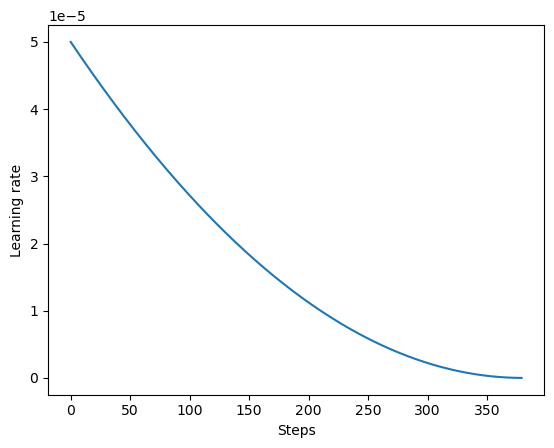

In [30]:
# Plotting the learning rate
plt.plot([lr_scheduler(step).numpy() for step in range(num_train_steps)])
plt.xlabel("Steps")
plt.ylabel("Learning rate")
plt.show()

In [31]:
# weights: tf.cast([[0.01192328,0.98807675]], dtype='float32')

def loss(labels, predictions, weights=tf.transpose(weights), from_logits=True):
#     print(predictions.shape)
#     print(weights.shape)

    example_losses = tf.losses.sparse_categorical_crossentropy(
      labels, predictions, from_logits=from_logits)

    if weights is None:
        return tf.reduce_mean(example_losses)
    weights = tf.cast(weights, predictions.dtype)
    return tf.reduce_mean(example_losses * weights)

# weights = tf.transpose(tf.cast([[0.01192328,0.98807675]], dtype='float32'))
weights

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.32142857],
       [0.6785714 ]], dtype=float32)>

In [32]:
import tensorflow as tf
from_logits=True

def loss(labels, predictions, weights=weights, from_logits=from_logits):
#     print(predictions.shape)
#     print(weights.shape)

    example_losses = tf.losses.sparse_categorical_crossentropy(
      labels, predictions, from_logits=from_logits)

    if weights is None:
        return tf.reduce_mean(example_losses)
    weights = tf.cast(weights, predictions.dtype)
    return tf.math.divide_no_nan(
      tf.reduce_sum(example_losses * weights), tf.reduce_sum(weights))

# weights = tf.transpose(tf.cast([[0.01192328,0.98807675]], dtype='float32'))
weights

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.32142857],
       [0.6785714 ]], dtype=float32)>

In [33]:
# Optimizer and loss function
opt = Adam(learning_rate=lr_scheduler)
# loss = SparseCategoricalCrossentropy(from_logits=True)

In [34]:
# Compiling the model
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [35]:
# filepath = './models/evidence_classification_model/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}'
# # earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='min')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, verbose=1, monitor='val_loss', mode='min')
# # reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

# # # Training the model
# history=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs, verbose=1, callbacks=[checkpoint])

In [36]:
print("Batch size: {} & Input Token Length: {}".format(batch_size, max_length))

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
#         print(logs)
#         print("epoch: ", epoch)
#         print(list(logs.keys()))
#         self.model.save("./classification_model/model_{}.hd5".format(epoch))
        self.model.save_pretrained("./models/evidence_classification_model/model.epoch{:02d}-loss{:.2f}".format(epoch, logs['val_loss']))
            
saver = CustomSaver()
# Training the model
history=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs, verbose=1, callbacks=[saver])

Batch size: 3 & Input Token Length: 512
Epoch 1/20
19/19 [==============================] - 33s 708ms/step - loss: 1.9399 - accuracy: 0.6250 - val_loss: 1.7880 - val_accuracy: 0.6842
Epoch 2/20
19/19 [==============================] - 17s 928ms/step - loss: 1.5221 - accuracy: 0.7857 - val_loss: 1.7069 - val_accuracy: 0.6842
Epoch 3/20
19/19 [==============================] - 9s 502ms/step - loss: 0.8118 - accuracy: 0.9643 - val_loss: 0.9253 - val_accuracy: 0.8947
Epoch 4/20
19/19 [==============================] - 10s 569ms/step - loss: 0.3078 - accuracy: 1.0000 - val_loss: 1.0245 - val_accuracy: 0.8421
Epoch 5/20
19/19 [==============================] - 10s 522ms/step - loss: 0.1658 - accuracy: 1.0000 - val_loss: 1.1476 - val_accuracy: 0.7895
Epoch 6/20
19/19 [==============================] - 10s 545ms/step - loss: 0.0979 - accuracy: 1.0000 - val_loss: 1.0665 - val_accuracy: 0.7895
Epoch 7/20
19/19 [==============================] - 11s 593ms/step - loss: 0.0490 - accuracy: 1.0000 - 

In [37]:
# # Training the model
# history=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

In [38]:
# # Saving the model
# model.save_pretrained(f"saved_model_epoch{num_epochs}")

In [39]:
df_dict = pd.DataFrame(history.history)
metric = 'val_loss'
epoch, val_loss = df_dict[df_dict[metric]==min(df_dict[metric])].index[0], df_dict[df_dict[metric]==min(df_dict[metric])]['val_loss'].item()

best_model_saved_path = "./models/evidence_classification_model/model.epoch{:02d}-loss{:.2f}".format(epoch, val_loss)

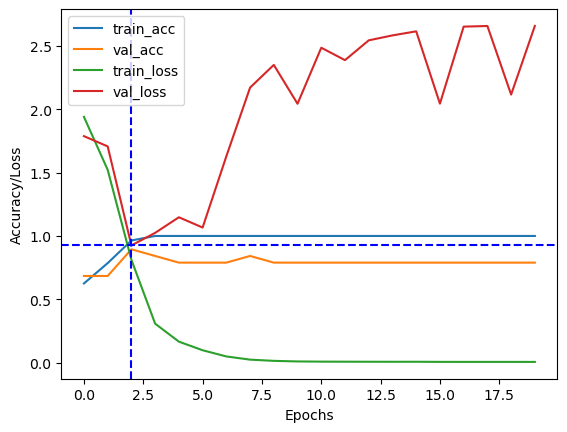

In [40]:
# Plotting the accuracy, training and validation loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(y=val_loss, color='b', linestyle='--')
plt.axvline(x=epoch, color='b', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'])
plt.show()

In [41]:
# Loading the Last saved model
print("Loading Best Model: ", best_model_saved_path)
trained_model = TFAutoModelForSequenceClassification.from_pretrained(best_model_saved_path,num_labels = num_classes)

Loading Best Model:  ./models/evidence_classification_model/model.epoch02-loss0.93


Some layers from the model checkpoint at ./models/evidence_classification_model/model.epoch02-loss0.93 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./models/evidence_classification_model/model.epoch02-loss0.93.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without furth

In [42]:
# Function to check similarity
def check_similarity(rumor, timeline, debug = 0):
    tokenizer_output = tokenizer(rumor, timeline, truncation=True, max_length = max_length, return_tensors = 'tf')
    logits = trained_model(**tokenizer_output)["logits"]
    tf.nn.softmax(logits, axis=1).numpy()[0][0]
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    if predicted_class_id == 1:
        if(debug):
            print("Timeline Provides Evidence to Rumor")
        return 1
    else:
        if(debug):
            print("Timeline Doesn't Provides Evidence to Rumor")
        return 0

In [43]:
# Checking no evidence between rumor and timeline
rumor = "Naturalization decree in preparation: Lebanese passports for sale?! https://t.co/UuQ7yMbSWJ https://t.co/Jf1K1NbZJD"
timeline = '“The Information Office of the Presidency of the Republic denies a false news broadcast by the MTV station about Baabda Palace preparing a decree naturalizing 4,000 people, and recalls that it had denied yesterday the false information published by the French magazine ‘Liberation’ about the same fabricated news. " “The Information Office of the Presidency of the Republic: What was published by the French newspaper “Liberation” about the “selling” of Lebanese passports to non-Lebanese is false and baseless news.'
check_similarity(rumor, timeline, 1)

Timeline Doesn't Provides Evidence to Rumor


0

In [44]:
# Checking evidence between rumor and timeline
rumor = "Urgent: Libya announces the opening of new corridors with Tunisia https://t.co/O8YgvmqKaQ"
timeline = "Opening new corridors with sister #Tunisia at the Ras Jdir crossing to facilitate the crossing of citizens from both countries. #Libya #Return_to_life #We_will_not_let_you #The_bear https://t.co/0ClsmKPVjb"
check_similarity(rumor, timeline, 1)

Timeline Provides Evidence to Rumor


1

### Testing the model on validation set and test set

In [45]:
import swifter

In [46]:
# checking accuracy on val data
val_df = pd.read_csv("val_evidence_clean.csv")
val_df['predicted'] = val_df.swifter.apply(lambda row: check_similarity(row['rumor'], row['evidence']), axis=1)

Pandas Apply: 100%|████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.01it/s]


In [47]:
# checking metrics on val data
val_df['predicted'] = val_df['predicted'].astype(int)
val_df['label'] = val_df['label'].astype(int)
print("Accuracy on Validation data is ",round(accuracy_score(val_df['label'],val_df['predicted'])*100,2))
print("Precision on Validation data is ",round(precision_score(val_df['label'],val_df['predicted'])*100,2))
print("Recall on Validation data is ",round(recall_score(val_df['label'],val_df['predicted'])*100,2))
print("F1 score on Validation data is ",round(f1_score(val_df['label'],val_df['predicted'])*100,2))
print("ROC AUC score on Validation data is ",round(roc_auc_score(val_df['label'],val_df['predicted'])*100,2))

Accuracy on Validation data is  89.47
Precision on Validation data is  83.33
Recall on Validation data is  83.33
F1 score on Validation data is  83.33
ROC AUC score on Validation data is  87.82


In [48]:
print(val_df['label'].value_counts())
print(val_df['predicted'].value_counts())

label
0    13
1     6
Name: count, dtype: int64
predicted
0    13
1     6
Name: count, dtype: int64


In [49]:
# # checking accuracy on test data
# test_df = pd.read_csv("test_clean.csv").sample(1000)
# test_df['predicted'] = test_df.swifter.apply(lambda row: check_similarity(row['rumor'], row['timeline']), axis=1)

In [50]:
# # checking metrics on test data
# test_df['predicted'] = test_df['predicted'].astype(int)
# test_df['is_evidence'] = test_df['is_evidence'].astype(int)
# print("Accuracy on test data is ",round(accuracy_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("Precision on test data is ",round(precision_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("Recall on test data is ",round(recall_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("F1 score on test data is ",round(f1_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("ROC AUC score on test data is ",round(roc_auc_score(test_df['is_evidence'],test_df['predicted'])*100,2))

In [51]:
# Function to check similarity
def predict_proba(rumor, timeline, debug = 0):
    tokenizer_output = tokenizer(rumor, timeline, truncation=True, max_length = max_length, return_tensors = 'tf', padding=True)
    logits = trained_model(**tokenizer_output)["logits"]
    predicted_proba_class_id = tf.nn.softmax(logits, axis=1).numpy()[0][1]
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    if predicted_class_id == 1:
        if(debug):
            print("SUPPORTS Rumor")
    else:
        if(debug):
            print("REFUTES Rumor")
    return predicted_proba_class_id

In [52]:
# checking accuracy on val data
val_df = pd.read_csv("val_evidence_clean.csv")
val_df['predicted'] = val_df.swifter.apply(lambda row: predict_proba(row['rumor'], row['evidence']), axis=1)

Pandas Apply: 100%|████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.06it/s]


In [53]:
val_df

,rumor,label,evidence,predicted
0,naturalization decree in preparation lebanese ...,0,aThe Information Office of the Presidency of t...,0.039725
1,in the video the spread of unidentified gunman...,0,the security force of all type and formation b...,0.045389
2,Riyad Salama to NBN raise the value of the dol...,0,after circulate news that the Governor of the ...,0.033540
3,Qatar throw iranian pea into garbage for fear ...,0,the competent supervisory agency in the munici...,0.603895
4,what Moza do towards the yemeni people be reso...,0,RT friend who have receive Haya card and then ...,0.079510
5,Libya Sources of the event news of the arrival...,0,there be no american delegation head to Bengha...,0.065388
6,Kuwait an officer with the rank of lieutenant ...,0,security Media the General Administration of R...,0.034778
7,with clear and clear title aYou will pay meani...,0,ministryofinterior there be no truth to what b...,0.032454
8,dutch inspection team be prevent from enter th...,0,this afternoon Army Commander General Joseph A...,0.173035
9,news of missile pass over Kuwaiti airspace com...,0,the Chief of Staff deny what be be circulate t...,0.073008


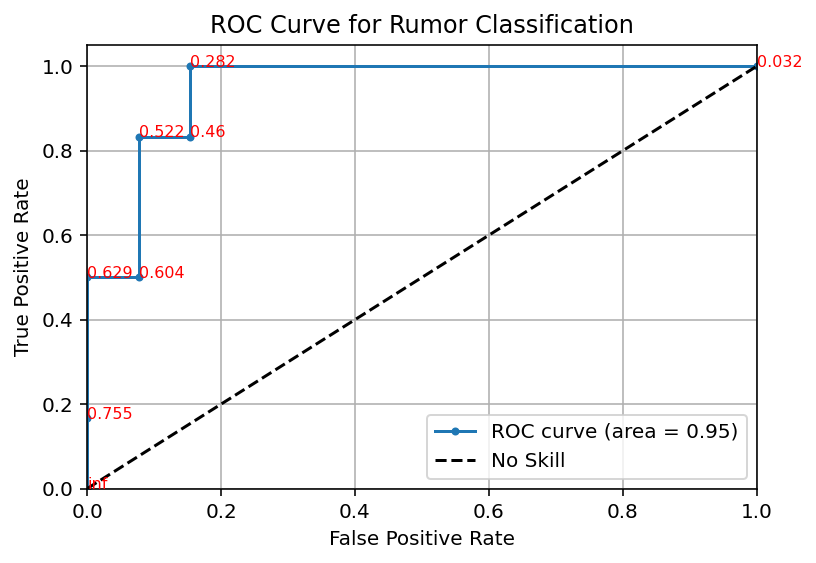

In [54]:
import matplotlib.pyplot as plt

y_test = val_df['label']
y_pred_proba = val_df['predicted']


from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
fig = plt.figure(figsize=(6,4),dpi=144)
ax = fig.add_subplot(111)
plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
for w,xx,yy in zip(thresholds,fpr,tpr):
        ax.annotate(round(w,3), xy=(xx,yy), fontsize=8, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Rumor Classification')
plt.grid()
plt.legend()
plt.show()

In [55]:
val_df

,rumor,label,evidence,predicted
0,naturalization decree in preparation lebanese ...,0,aThe Information Office of the Presidency of t...,0.039725
1,in the video the spread of unidentified gunman...,0,the security force of all type and formation b...,0.045389
2,Riyad Salama to NBN raise the value of the dol...,0,after circulate news that the Governor of the ...,0.033540
3,Qatar throw iranian pea into garbage for fear ...,0,the competent supervisory agency in the munici...,0.603895
4,what Moza do towards the yemeni people be reso...,0,RT friend who have receive Haya card and then ...,0.079510
5,Libya Sources of the event news of the arrival...,0,there be no american delegation head to Bengha...,0.065388
6,Kuwait an officer with the rank of lieutenant ...,0,security Media the General Administration of R...,0.034778
7,with clear and clear title aYou will pay meani...,0,ministryofinterior there be no truth to what b...,0.032454
8,dutch inspection team be prevent from enter th...,0,this afternoon Army Commander General Joseph A...,0.173035
9,news of missile pass over Kuwaiti airspace com...,0,the Chief of Staff deny what be be circulate t...,0.073008


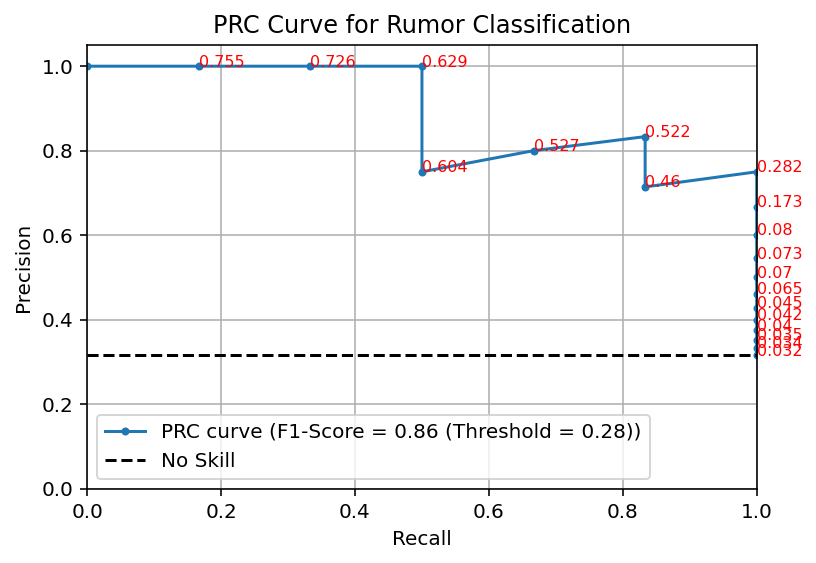

In [56]:
# threshold = 0.887

from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
# Calculate PRC curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba) 

numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
threshold = thresholds[np.argmax(f1_scores)] # MAX F1 THRESHOLD

y_pred = [1 if i>=threshold else 0 for i in y_pred_proba]
f1score = f1_score(y_test, y_pred)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
fig = plt.figure(figsize=(6,4),dpi=144)
ax = fig.add_subplot(111)
plt.plot(recall, precision, marker='.', label='PRC curve (F1-Score = %0.2f (Threshold = %0.3f))' % (f1score, threshold))
plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')
for w,xx,yy in zip(thresholds, recall, precision):
        ax.annotate(round(w,3), xy=(xx,yy), fontsize=8, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC Curve for Rumor Classification')
plt.grid()
plt.legend()
plt.show()

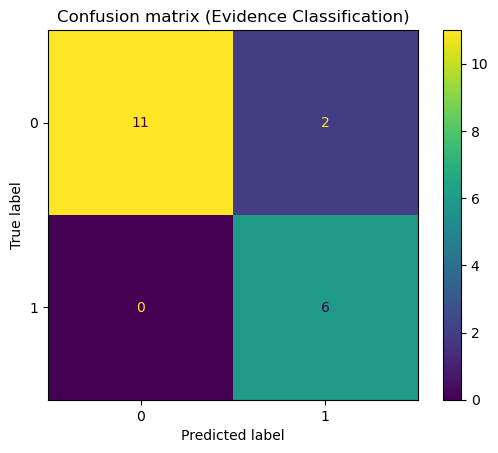

In [57]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.title('Confusion matrix (Evidence Classification)')
plt.show()

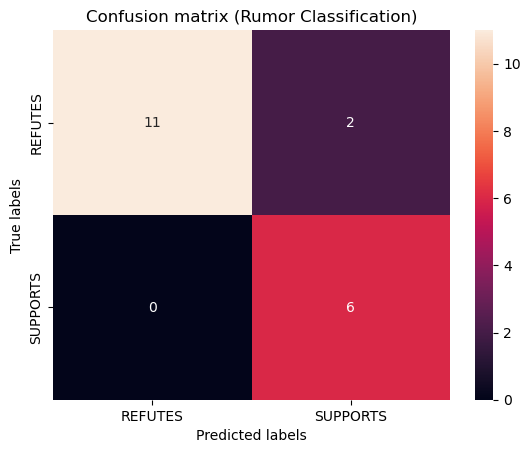

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix (Rumor Classification)'); 
ax.xaxis.set_ticklabels(['REFUTES', 'SUPPORTS']); ax.yaxis.set_ticklabels(['REFUTES', 'SUPPORTS']);

In [59]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [61]:
# tf.keras.utils.plot_model(model, show_dtype=True, 
#                        show_layer_names=True, show_shapes=True,  
#                        to_file='model.png')